# Chignolin

In [2]:
import pyemma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import multiprocessing
from collections import Counter
import copy
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

# NMM modules
import sys
sys.path.append('/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath')
from nmm import NonMarkovModel, MarkovPlusColorModel, DiscretePathEnsemble

## Auxiliary functions

In [202]:
def get_tps(trajs, ini_state, final_state, n_states, misfolded_state=[]):
    
    macro_dict = dict()
    for micro in ini_state:
        macro_dict[micro] = 0
    for micro in final_state:
        macro_dict[micro] = 2
    for micro in [x for x in range(n_states) if x not in ini_state+final_state]:
        macro_dict[micro] = 1
    
    tps_list=[]
    for traj in trajs:
        if isinstance(traj, np.ndarray): traj = traj.tolist()
        macro_traj = list(map(macro_dict.get, traj))
        tp=[]
        for i in range(0,len(macro_traj)):
            if macro_traj[i] == 0:
                tp = [traj[i]]
            elif macro_traj[i] == 2 and len(tp)>0:
                tp.append(traj[i])
                tps_list.append(np.array(tp))
                tp=[]
            elif len(tp)>0:
                tp.append(traj[i])
                
    if misfolded_state:
        tps_list_ = []
        for tps in tps_list:
            if not [microst for microst in tps if microst in misfolded_state]:
                tps_list_.append(tps)
        tps_list = tps_list_
                
    return(tps_list)

def _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state=[]):
    
    # keep only intermediate fragments (of indirect paths) for counts
    tps_indir = np.array([path[1:-1] for path in tps if len(path) > 2])

    # pdirect
    pdirect = len([path for path in tps if len(path) == 2]) / len(tps)

    # mean path length (length of direct paths taken to be zero)
    mean_length = np.sum([len(path) for path in tps_indir]) / len(tps)
    if mean_length == 0: mean_length = np.nan

    # counts (indirect only)
    if len(tps_indir) == 0:
        print('There are no indirect TPs!')
        return pdirect, mean_length, np.nan
    tps_indir_concat = np.concatenate(tps_indir)
    counter = Counter(tps_indir_concat)
    counts = [counter[i] for i in [x for x in range(n_states) if x not in stateA+stateB+misfolded_state]]
    counts = np.array(counts) / len(tps_indir_concat)

    return pdirect, mean_length, counts

def get_tps_stats(tps, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    if len(tps) == 0:
        print('There are no TPs!')
        return np.nan, np.nan, np.nan

    if bootstrap:
        bootstrap_counts = []
        bootstrap_pdirect = []
        bootstrap_mean_length = []
        for bootstrap_ in range(n_samples):
            tps_ = np.random.choice(tps, len(tps))
            
            pdirect, mean_length, counts = _get_tps_stats(tps_, stateA, stateB, n_states, misfolded_state)
            
            bootstrap_pdirect.append(pdirect)
            bootstrap_mean_length.append(mean_length)
            bootstrap_counts.append(counts)

        return bootstrap_pdirect, bootstrap_mean_length, bootstrap_counts
            
    else:
        return _get_tps_stats(tps, stateA, stateB, n_states, misfolded_state)

def get_tps_w_stats(dtrajs, stateA, stateB, n_states, bootstrap=False, n_samples=1000, misfolded_state=[]):
    
    tps = get_tps(dtrajs, stateA, stateB, n_states, misfolded_state) + get_tps(dtrajs, stateB, stateA, n_states, misfolded_state)
    pdirect, mean_length, counts = get_tps_stats(tps, stateA, stateB, n_states, bootstrap, n_samples, misfolded_state)
    
    return tps, pdirect, mean_length, counts

def simulate_msm(msm, sim_traj_length=1000000):
    
    np.random.seed()
    traj = msm.simulate(sim_traj_length)
    
    return [traj]

def simulate_hamsm(nm_tmatrix, stateA, stateB, sim_traj_length=3000000):
    
    np.random.seed()
    sim = NonMarkovModel.from_nm_tmatrix(nm_tmatrix, stateA, stateB, sim_length=sim_traj_length, initial_state=stateA[0])
    trajs = sim.trajectories
    
    return trajs

def estimate_simulate_msm(dtrajs, lag, sim_traj_length=1000000):
    
    msm = pyemma.msm.estimate_markov_model(list(dtrajs), lag)
    trajs = simulate_msm(msm, sim_traj_length=sim_traj_length)
    
    return msm, trajs

def estimate_simulate_hamsm(dtrajs, stateA, stateB, hist_length='all', sim_traj_length=3000000):
    
    if hist_length == 'all':
        nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=1, clean_traj=True)
    else:
        nm_model = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=1, hist_length=hist_length, clean_traj=True)
    
    trajs = simulate_hamsm(nm_model.nm_tmatrix, stateA, stateB, sim_traj_length)
    
    return nm_model, trajs

def coarsegrain_paths(tps, state_dict, stateA, stateB):

    tps_coarse = []

    for path in tps:
        if isinstance(path, np.ndarray): path = path.tolist()
        path_ = []
        for state in path:
            if state in stateA:
                path_.append(state_dict['A'])
            elif state in stateB:
                path_.append(state_dict['B'])
            else:
                path_.append(state_dict[state])
        if path_[0] == state_dict['B']:
            path_ = path_[::-1]
        tps_coarse.append(path_)
        
    return tps_coarse

def get_fundamental_sequences(tps, stateA, stateB, nm_dict, markov_tmatrix, bootstrap=False, n_samples=1000):
    
    # keep only intermediate fragments (of indirect paths)
    tps_ = [path for path in tps if len(path) > 2]   
    tps_coarse = coarsegrain_paths(tps_, nm_dict, stateA, stateB)
    
    if bootstrap:
        bootstrap_FS = []
        bootstrap_FSweights = []
        for bootstrap in range(n_samples):
            tps_coarse_ = np.random.choice(tps_coarse, len(tps_coarse))
            
            ens = DiscretePathEnsemble(tps_coarse_, stateA=stateA, stateB=stateB)
            FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)
            
            bootstrap_FS.append(FS)
            bootstrap_FSweights.append(FSweights)
            
        return bootstrap_FS, bootstrap_FSweights    
    
    else:
        ens = DiscretePathEnsemble(tps_coarse, stateA=stateA, stateB=stateB)
        FS, FSweights, _ = ens.weighted_fundamental_sequences(markov_tmatrix)

        return FS, FSweights
    
def get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict):
    
    FSweights_common = np.zeros(len(FS_md))

    for j,seq in enumerate(FS):
        if seq in FS_md_indexdict:
            FSweights_common[FS_md_indexdict[seq]] = FSweights[j]
            
    return FSweights_common

def abs_error(x,y):

    abs_error = np.sum(np.abs(x-y))
        
    return abs_error

## Read MD data

In [219]:
system_name = 'Chignolin'

dtrajs = list(np.load('../../top_models/chignolin/chignolin_dtrajs.npy'))

msm = pyemma.msm.estimate_markov_model(dtrajs, 150*5)
pcca = msm.pcca(2)

# unfolded
stateA_index = np.argmax([len(x) for x in pcca.metastable_sets])
# folded
stateB_index = np.argmin([len(x) for x in pcca.metastable_sets])

cutoff = 0.5
intermediate_len = 0
while intermediate_len < 0.1*msm.nstates:
           
    cutoff += 0.001 # adjust to make possible to get desired intermediate

    stateA = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
    stateB = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

    intermediate_len = msm.nstates - len(stateA) - len(stateB)   

In [220]:
print('Intermediate size: {}, cutoff: {}'.format(intermediate_len, cutoff))
print('Unfolded size: {}, folded size: {}'.format(len(stateA), len(stateB)))

Intermediate size: 10, cutoff: 0.8290000000000003
Unfolded size: 70, folded size: 20


## Estimate MSMs and simulate long trajectories

In [9]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

In [10]:
pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, [(dtrajs, lag) for lag in lags])
pool.close()
pool.join()

msms = [x[0] for x in out]
dtrajs_msms = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms.npy'.format(system_name), dtrajs_msms)
# OR RELOAD
# dtrajs_msms = np.load('{}_dtrajs_msms.npy'.format(system_name), allow_pickle=True)

## Estimate haMSMs and simulate long trajectories

In [11]:
remove_for_eq = int(np.mean([msms[7].mfpt(stateA, stateB), msms[7].mfpt(stateB, stateA)]))
dtrajs_nm = []

dtrajs_ = copy.deepcopy(dtrajs)
for traj in dtrajs_:
    dtrajs_nm.append(traj[remove_for_eq:])
    dtrajs_nm.append(traj[remove_for_eq:][::-1])

np.save('{}_dtrajs_nm.npy'.format(system_name), dtrajs_nm)
# OR RELOAD
# dtrajs_nm = np.load('{}_dtrajs_nm.npy'.format(system_name), allow_pickle=True)

dtrajs_nm = [x.tolist() for x in dtrajs_nm]

In [12]:
hist_lengths = ['all', 5, 10, 20, 50, 250, 500]
pool = multiprocessing.Pool(7)
out = pool.starmap(estimate_simulate_hamsm, [(dtrajs_nm, stateA, stateB, hist_length) for hist_length in hist_lengths])
pool.close()
pool.join()

hamsms = [x[0] for x in out]
dtrajs_hamsms = [x[1] for x in out]
del out

np.save('{}_dtrajs_hamsms.npy'.format(system_name), dtrajs_hamsms)
# OR RELOAD
# dtrajs_hamsms = np.load('{}_dtrajs_hamsms.npy'.format(system_name), allow_pickle=True)

# 10 intermediate states: p(x|TP) (indirect paths only)

## MD

In [13]:
tps_md, pdirect_md, mean_length_md, counts_md = get_tps_w_stats(dtrajs, stateA, stateB, n_states=100, bootstrap=True, n_samples=1000)

In [14]:
len(tps_md), len([path for path in tps_md if len(path) > 2]) # all, and indirect paths only

(460, 236)

## MSMs

In [15]:
tps_msms = []
pdirect_msms = []
mean_length_msms = []
counts_msms = []

for dtrajs_ in dtrajs_msms:
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_, stateA, stateB, n_states=100)
    
    tps_msms.append(tps)
    pdirect_msms.append(pdirect)
    mean_length_msms.append(mean_length)
    counts_msms.append(counts)

In [16]:
# all paths
[len(tps) for tps in tps_msms]

[1844, 3094, 4409, 6182, 11242, 41115, 72934, 121861, 280252]

In [17]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_msms]

[1416, 2359, 3029, 3921, 5608, 8540, 9999, 11550, 10500]

## haMSMs

In [18]:
tps_hamsms = []
pdirect_hamsms = []
mean_length_hamsms = []
counts_hamsms = []

for dtrajs_ in dtrajs_hamsms:
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_, stateA, stateB, n_states=100)
    
    tps_hamsms.append(tps)
    pdirect_hamsms.append(pdirect)
    mean_length_hamsms.append(mean_length)
    counts_hamsms.append(counts)

In [19]:
# all paths
[len(tps) for tps in tps_hamsms]

[2575, 3195, 2916, 2768, 2573, 2617, 2561]

In [20]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_hamsms]

[1333, 1905, 1580, 1459, 1346, 1339, 1310]

## plot

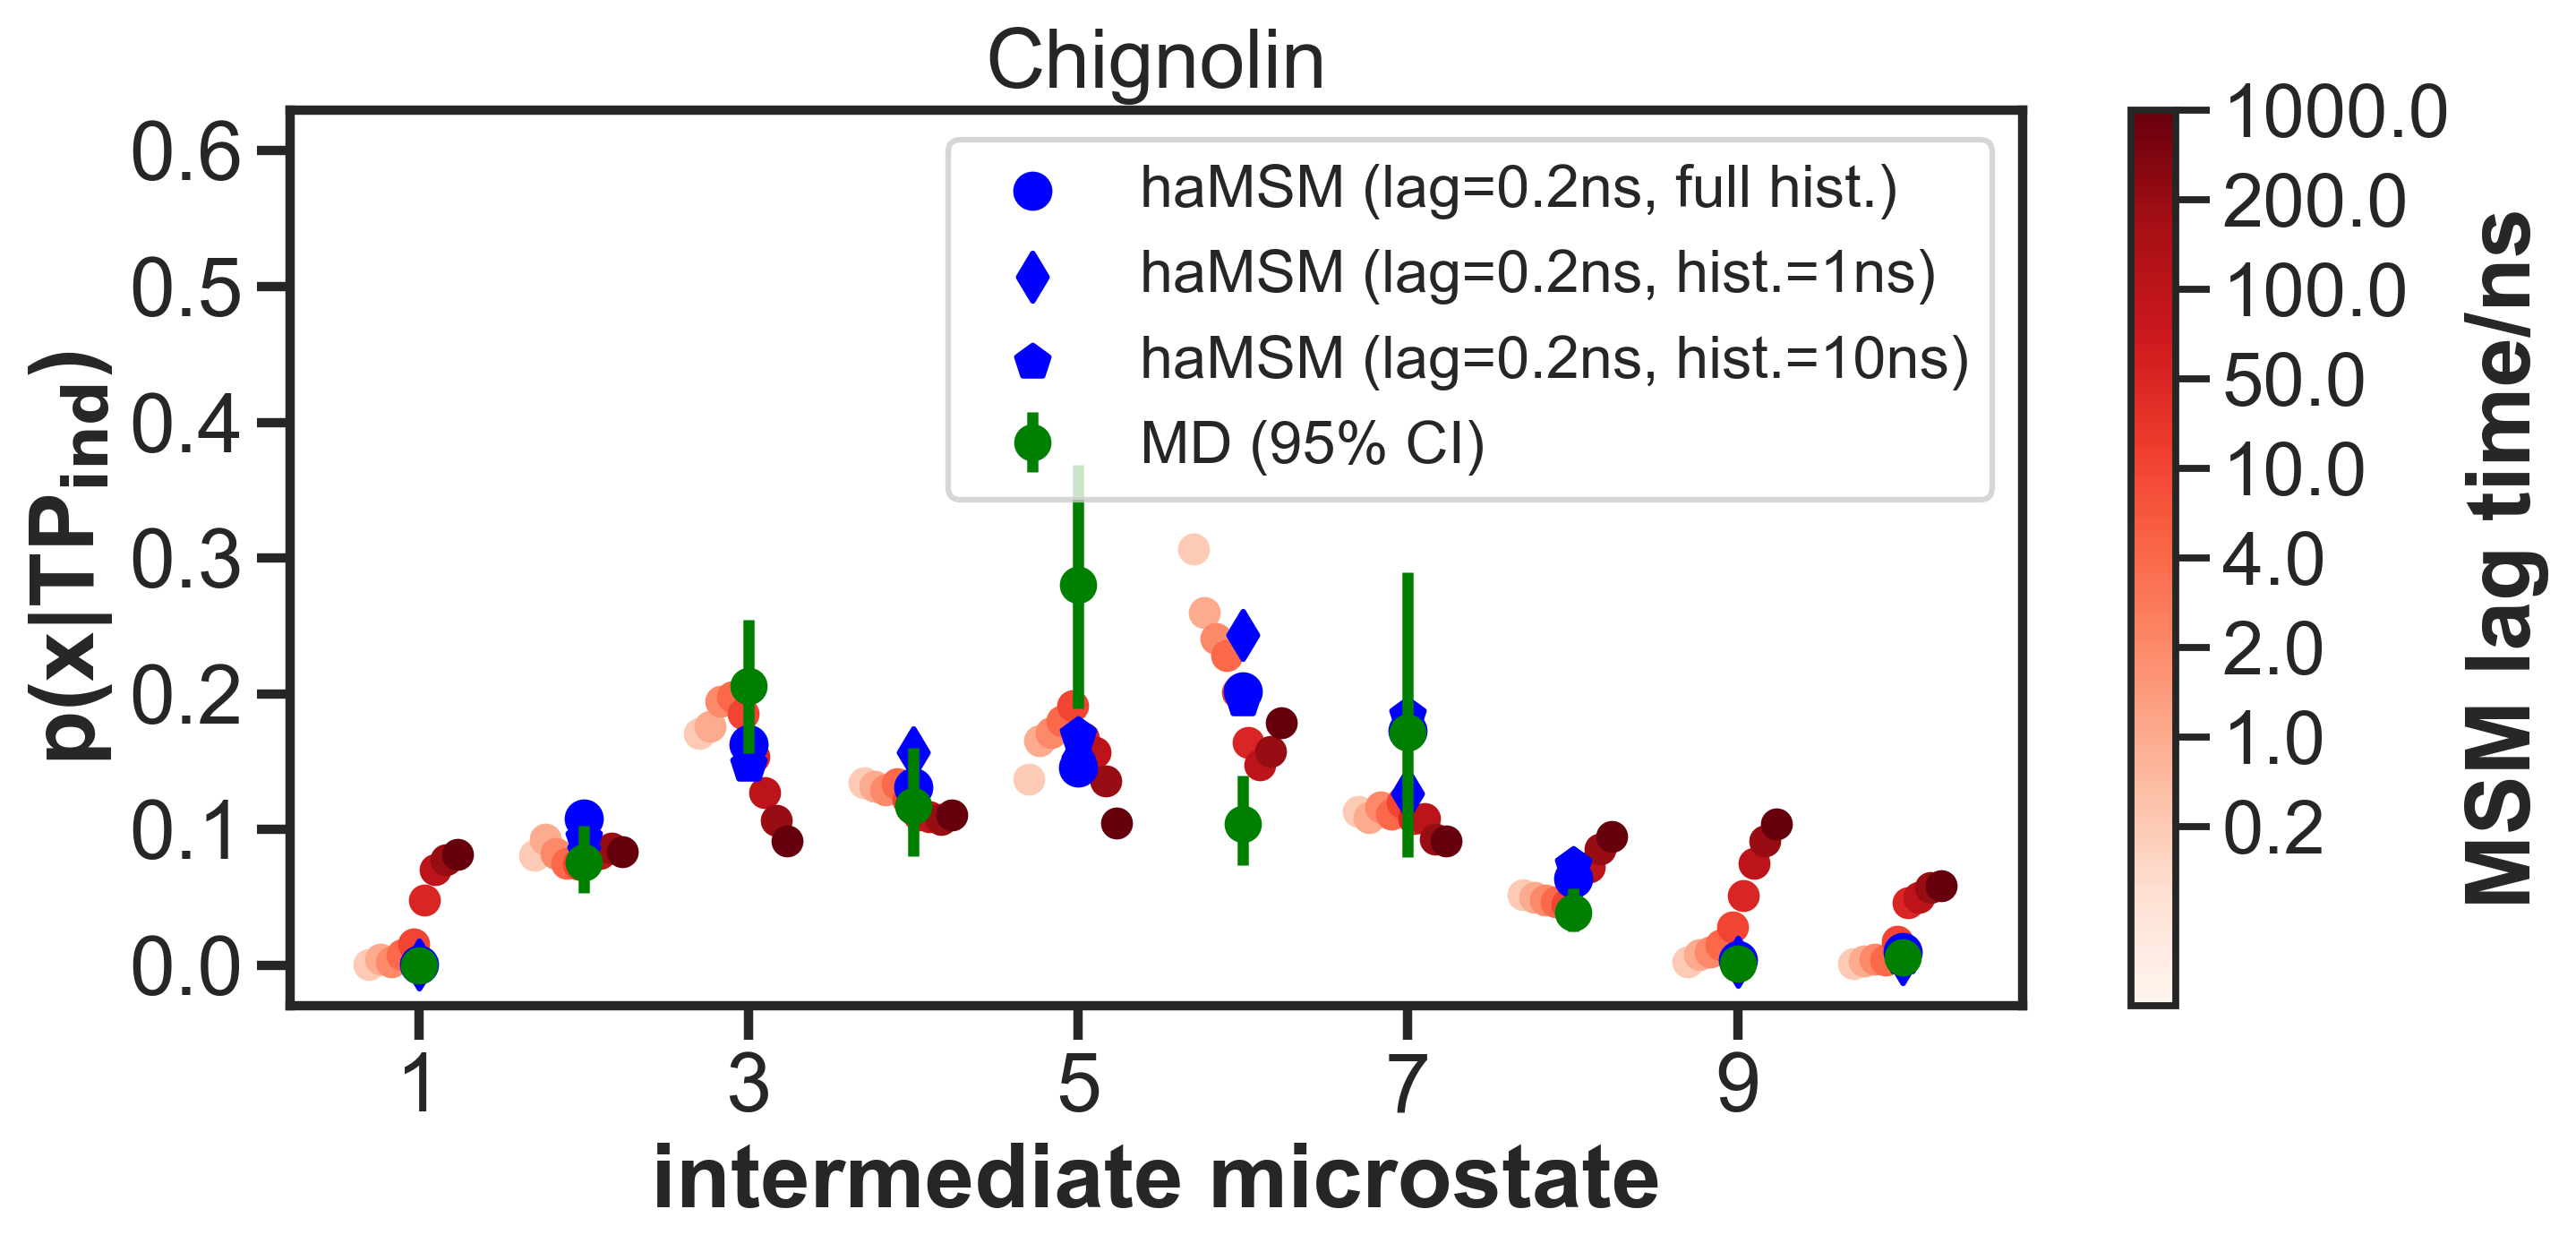

In [128]:
fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,10.5), counts_msms[msm_index], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=20)

plt.errorbar(range(1,11), np.mean(counts_md, axis=0), 
             yerr=[(np.mean(counts_md, axis=0)-np.percentile(counts_md, 2.5, axis=0)), 
                   (np.percentile(counts_md, 97.5, axis=0)-np.mean(counts_md, axis=0))], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

plt.scatter(np.arange(1,11), counts_hamsms[0], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
plt.scatter(np.arange(1,11), counts_hamsms[1], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
plt.scatter(np.arange(1,11), counts_hamsms[4], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('intermediate microstate', fontsize=24, weight='bold')
plt.ylabel('p(x|TP$_\mathbf{ind}$)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,10,2), np.arange(1,10,2), fontsize=22)
plt.yticks(np.arange(0, 0.63, 0.1), fontsize=22)
plt.ylim(-0.03, 0.63)
plt.title('{}'.format(system_name), fontsize=22)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig('{}_pxTP_main.pdf'.format(system_name))

plt.show()

# 10 intermediate states: fundamental sequences (indirect paths only)

## new haMSM estimation with coarse macrostates

In [36]:
dtrajs_nm_ = copy.deepcopy(dtrajs_nm) # coarse_macrostates = True modifies dtrajs
nm_model = NonMarkovModel(dtrajs_nm_, stateA, stateB, lag_time=1, coarse_macrostates=True) 

In [37]:
# make micro --> macro dictionary for path coarse-graining
nm_dict = dict()
nm_dict['A'] = nm_model.stateA[0]
nm_dict['B'] = nm_model.stateB[0]

for i in range(len(dtrajs_nm[0])):
    if len(nm_dict) == nm_model.n_states:
        break
    if dtrajs_nm[0][i] not in stateA+stateB:  
        nm_dict[dtrajs_nm[0][i]] = nm_model.trajectories[0][i]

## MD 

In [38]:
FS_md, FSweights_md = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix)

FS_md_bootstrap, FSweights_md_bootstrap = get_fundamental_sequences(tps_md, stateA, stateB, nm_dict, nm_model.markov_tmatrix, bootstrap=True, n_samples=1000)

## MSMs

In [39]:
FS_msms = []
FSweights_msms = []

for i,tps in enumerate(tps_msms):
    nm_model.lag_time = lags[i]
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_msms.append(FS)
    FSweights_msms.append(FSweights)       

nm_model.lag_time = 1    

## haMSMs

In [40]:
FS_hamsms = []
FSweights_hamsms = []

for i,tps in enumerate(tps_hamsms):
    FS, FSweights = get_fundamental_sequences(tps, stateA, stateB, nm_dict, nm_model.markov_tmatrix)
    FS_hamsms.append(FS)
    FSweights_hamsms.append(FSweights)   

## find common fundamental sequences

In [41]:
FS_md_indexdict = dict()
for i,seq in enumerate(FS_md):
    FS_md_indexdict[seq] = i

# MD
FSweights_md_bootstrap_common = []
for i in range(len(FS_md_bootstrap)):
    FS = FS_md_bootstrap[i]
    FSweights = FSweights_md_bootstrap[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_md_bootstrap_common.append(FSweights_common)            

# MSMs
FSweights_msms_common = []
for i in range(len(FS_msms)):
    FS = FS_msms[i]
    FSweights = FSweights_msms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict) 
    FSweights_msms_common.append(FSweights_common)    

# haMSMs
FSweights_hamsms_common = []
for i in range(len(FS_hamsms)):
    FS = FS_hamsms[i]
    FSweights = FSweights_hamsms[i]
    FSweights_common = get_common_fundamental_sequences(FS, FSweights, FS_md, FS_md_indexdict)
    FSweights_hamsms_common.append(FSweights_common)     

## plot

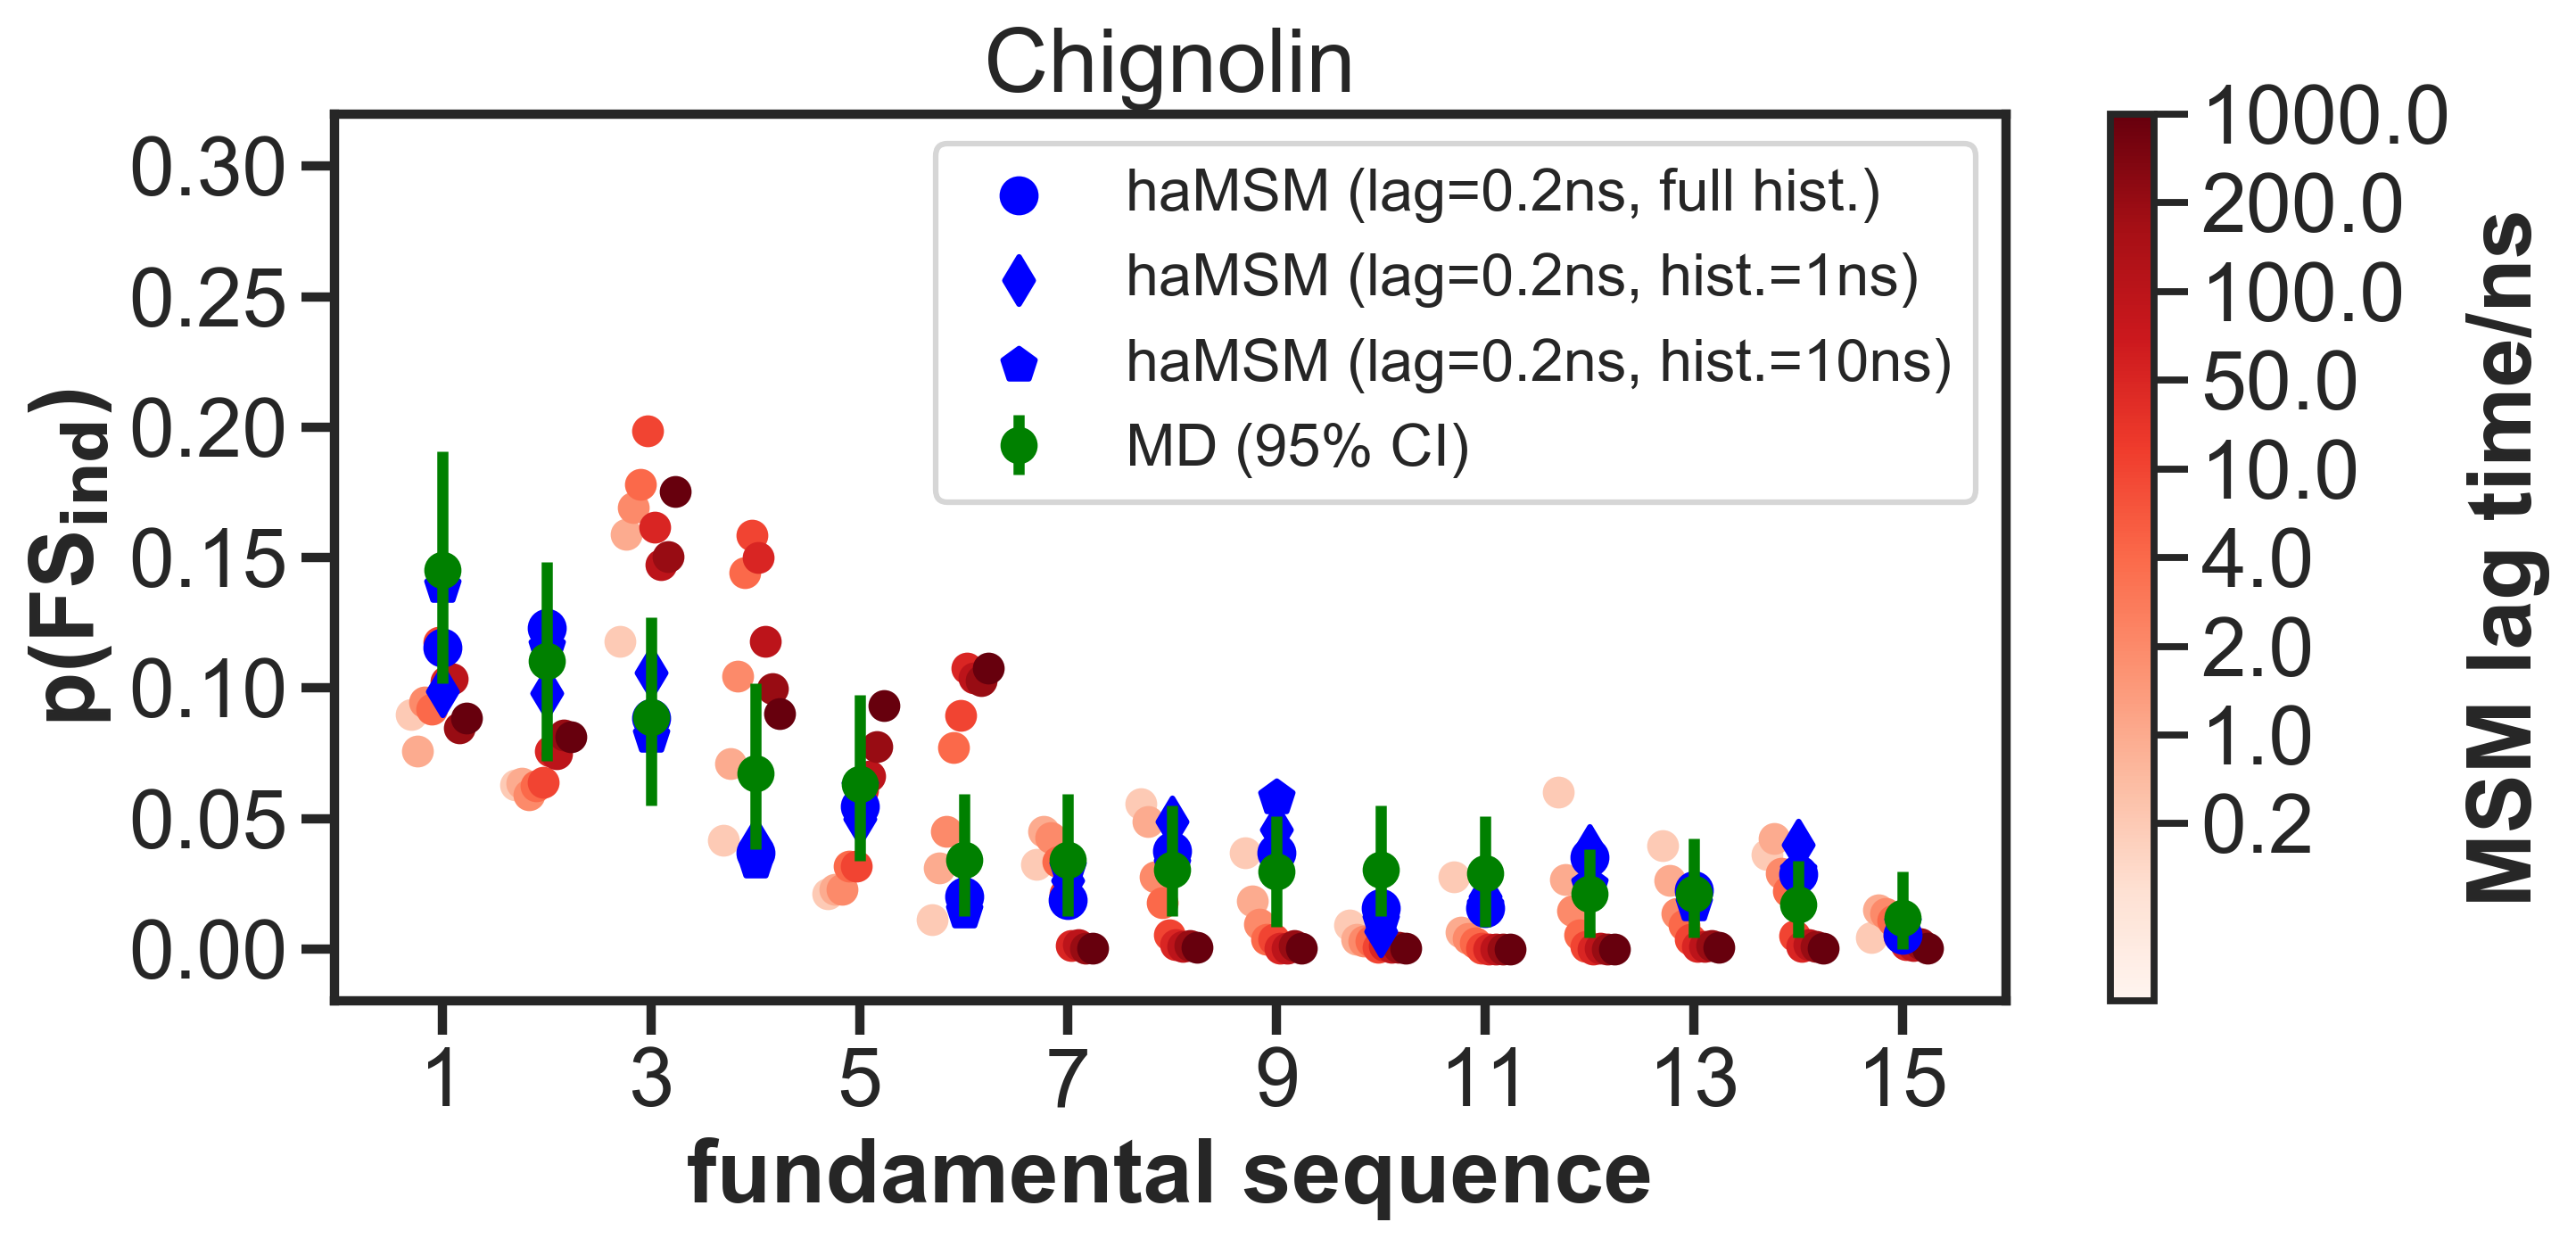

In [218]:
no_paths = 15

fig = plt.figure(dpi=300, figsize=(10,5))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
ax.tick_params(width=2.5)

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    plt.scatter(np.arange(0.7+0.2*msm_index/3,no_paths+0.5), 
                FSweights_msms_common[msm_index][:no_paths], color=cmap.to_rgba(msm_index), s=50)

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', fontsize=24, weight='bold')
cbar.ax.tick_params(labelsize=22)

plt.errorbar(range(1,no_paths+1), np.mean(FSweights_md_bootstrap_common, axis=0)[:no_paths], 
             yerr=[(np.mean(FSweights_md_bootstrap_common, axis=0)-np.percentile(FSweights_md_bootstrap_common, 2.5, axis=0))[:no_paths], 
                   (np.percentile(FSweights_md_bootstrap_common, 97.5, axis=0)-np.mean(FSweights_md_bootstrap_common, axis=0))[:no_paths]], 
             color='green', label='MD (95% CI)', fmt='o', elinewidth=3)

plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[0][:no_paths], color='blue', label='haMSM (lag=0.2ns, full hist.)', marker='o')
plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[1][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=1ns)', marker='d')
plt.scatter(np.arange(1,no_paths+1), FSweights_hamsms_common[4][:no_paths], color='blue', label='haMSM (lag=0.2ns, hist.=10ns)', marker='p')

plt.xlabel('fundamental sequence', fontsize=24, weight='bold')
plt.ylabel('p(FS$_\mathbf{ind}$)', fontsize=24, weight='bold')
plt.xticks(np.arange(1,no_paths+1,2), np.arange(1,no_paths+1,2), fontsize=22)
plt.yticks(np.arange(0, 0.35, 0.05), fontsize=22)
plt.ylim(-0.02, 0.32)
plt.title('{}'.format(system_name), fontsize=24)
plt.legend(fontsize=16)

plt.tight_layout()
plt.savefig('{}_pFS_main.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, stride = 0.2 ns

## choose PCCA cutoffs 

In [82]:
stateAs = []
stateBs = []
intermediate_lens = []

for i in np.arange(0.05, 0.8, 0.1):

    cutoff = 0.5
    intermediate_len = 0
    while intermediate_len < i*msm.nstates:
        
        cutoff += 0.001 # adjust to make possible to get 10% intermediate

        stateA_ = np.concatenate(np.argwhere(pcca.memberships[:,stateA_index] > cutoff)).tolist()
        stateB_ = np.concatenate(np.argwhere(pcca.memberships[:,stateB_index] > cutoff)).tolist()

        intermediate_len = msm.nstates - len(stateA_) - len(stateB_) 
        
    stateAs.append(stateA_)
    stateBs.append(stateB_)
    intermediate_lens.append(intermediate_len)

intermediate_lens = np.array(intermediate_lens)

In [83]:
intermediate_lens

array([ 5, 16, 26, 35, 47, 56, 66, 76])

## MD

In [192]:
tps_md_cutoffs = []
pdirect_md_cutoffs = []
length_md_cutoffs = []
counts_md_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs, stateA_, stateB_, n_states=100, bootstrap=True, n_samples=1000)

    tps_md_cutoffs.append(tps)
    pdirect_md_cutoffs.append(pdirect)
    length_md_cutoffs.append(mean_length)
    counts_md_cutoffs.append(counts)

In [193]:
# all paths
[len(tps) for tps in tps_md_cutoffs]

[804, 446, 446, 440, 426, 406, 378, 257]

In [194]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_md_cutoffs]

[375, 256, 261, 272, 290, 293, 291, 252]

## MSMs

In [195]:
tps_msms_cutoffs = []
pdirect_msms_cutoffs = []
length_msms_cutoffs = []
counts_msms_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs.append(tps_)
    pdirect_msms_cutoffs.append(pdirect_)
    length_msms_cutoffs.append(length_)
    counts_msms_cutoffs.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs = [x * lags for x in length_msms_cutoffs]

In [196]:
# all paths
for i in range(len(intermediate_lens)):
    print([len(tps) for tps in tps_msms_cutoffs[i]])

[2178, 3408, 4709, 6436, 11556, 41601, 73882, 124577, 288966]
[1780, 2990, 4295, 6022, 11030, 40595, 71368, 118067, 264252]
[1780, 2990, 4275, 5994, 10928, 39441, 67802, 108317, 226466]
[1776, 2968, 4247, 5926, 10808, 38369, 64462, 100471, 197566]
[1750, 2922, 4175, 5830, 10620, 36429, 59320, 87669, 157174]
[1740, 2906, 4133, 5760, 10340, 33369, 51730, 71317, 113692]
[1692, 2834, 4043, 5562, 9776, 27994, 39828, 50123, 68826]
[1216, 2098, 2888, 3776, 5938, 10324, 11652, 11834, 13208]


In [197]:
# indirect paths only
for i in range(len(intermediate_lens)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs[i]])

[1393, 2021, 2467, 3086, 4079, 5454, 5994, 6330, 5193]
[1405, 2370, 3108, 4075, 6305, 11193, 14170, 17171, 15473]
[1419, 2423, 3264, 4443, 7186, 15948, 22314, 28099, 24189]
[1444, 2514, 3477, 4788, 7843, 19078, 27041, 33935, 27611]
[1469, 2562, 3590, 5001, 8488, 22130, 31382, 38526, 28976]
[1512, 2600, 3700, 5179, 8904, 23734, 32763, 38477, 26008]
[1510, 2610, 3705, 5105, 8836, 22503, 28805, 31753, 18313]
[1208, 2073, 2845, 3682, 5725, 9148, 9650, 8881, 3689]


## haMSMs: estimate and simulate

In [90]:
pool = multiprocessing.Pool(8)

arguments = []
for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    arguments.append((dtrajs_nm, stateA_, stateB_, 'all'))

out = pool.starmap(estimate_simulate_hamsm, arguments)
pool.close()
pool.join()

hamsms_cutoffs = [x[0] for x in out]
dtrajs_hamsms_cutoffs = [x[1] for x in out]
del out

np.save('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), dtrajs_hamsms_cutoffs)
# OR RELOAD
# dtrajs_hamsms_cutoffs = np.load('{}_dtrajs_hamsms_cutoffs.npy'.format(system_name), allow_pickle=True)

## haMSMs: count

In [198]:
tps_hamsms_cutoffs = []
pdirect_hamsms_cutoffs = []
length_hamsms_cutoffs = []
counts_hamsms_cutoffs = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_hamsms_cutoffs[i], stateA_, stateB_, n_states=100)

    tps_hamsms_cutoffs.append(tps)
    pdirect_hamsms_cutoffs.append(pdirect)
    length_hamsms_cutoffs.append(mean_length)
    counts_hamsms_cutoffs.append(counts)

In [199]:
# all paths
[len(tps) for tps in tps_hamsms_cutoffs]

[4496, 2563, 2549, 2517, 2352, 2334, 2142, 1513]

In [200]:
# indirect paths only
[len([path for path in tps if len(path) > 2]) for tps in tps_hamsms_cutoffs]

[2060, 1439, 1481, 1560, 1582, 1650, 1641, 1473]

## plot: p(direct TP)

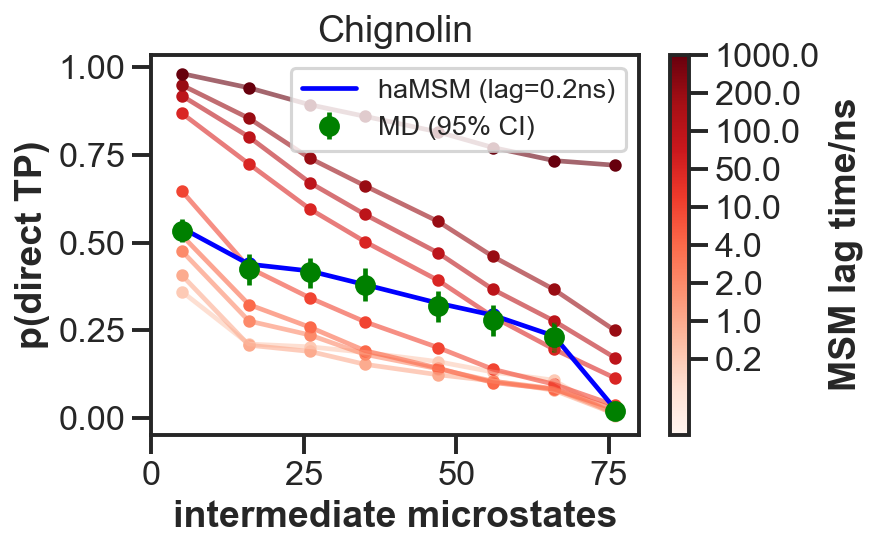

In [190]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

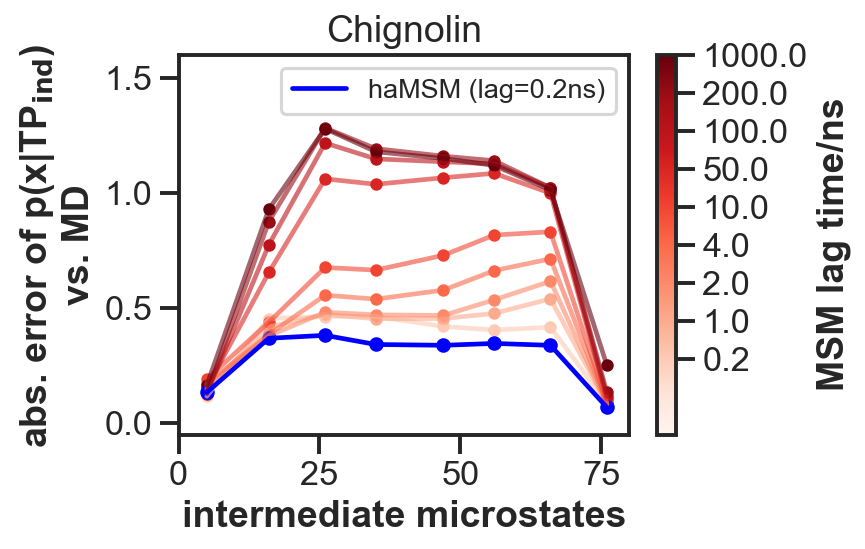

In [207]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs[i][msm_index]) for i in range(len(counts_msms_cutoffs))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')    

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('abs. error of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
plt.xticks(range(0,100,25))
plt.ylim(-0.05,1.6)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates.pdf'.format(system_name))

plt.show()

## plot: mean TP length

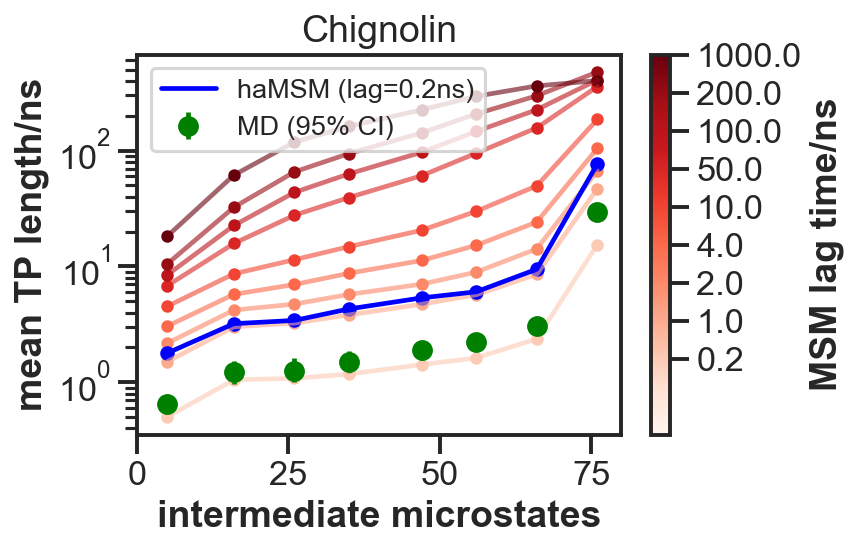

In [210]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag time/ns', weight='bold')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13, loc='upper left')

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates.pdf'.format(system_name))

plt.show()

# Multiple numbers of intermediate states, MSMs trained on stride = lag

## MSMs: estimate and simulate

In [170]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

pool = multiprocessing.Pool(8)
out = pool.starmap(estimate_simulate_msm, ([([dtrajs[0][::lag]], 1) for lag in lags]))
pool.close()
pool.join()

msms_strides = [x[0] for x in out]
dtrajs_msms_strides = [x[1] for x in out]
del out

np.save('{}_dtrajs_msms_strides.npy'.format(system_name), dtrajs_msms_strides)
# OR RELOAD
# dtrajs_msms_strides = np.load('{}_dtrajs_msms_strides.npy'.format(system_name), allow_pickle=True)

## MSMs: count

In [211]:
tps_msms_cutoffs_strides = []
pdirect_msms_cutoffs_strides = []
length_msms_cutoffs_strides = []
counts_msms_cutoffs_strides = []

for i in range(len(intermediate_lens)):
    
    stateA_= stateAs[i] # unfolded
    stateB_ = stateBs[i] # folded
    
    tps_ = []
    pdirect_ = []
    length_ = []
    counts_ = []

    for dtrajs_msm in dtrajs_msms_strides:
        tps, pdirect, mean_length, counts = get_tps_w_stats(dtrajs_msm, stateA_, stateB_, n_states=100)
        tps_.append(tps)
        pdirect_.append(pdirect)
        length_.append(mean_length)
        counts_.append(counts)
        
    tps_msms_cutoffs_strides.append(tps_)
    pdirect_msms_cutoffs_strides.append(pdirect_)
    length_msms_cutoffs_strides.append(length_)
    counts_msms_cutoffs_strides.append(counts_)
    
# multiply mean path lengths by lag times to have all in 0.2 ns steps for comparison
length_msms_cutoffs_strides = [x * lags for x in length_msms_cutoffs_strides]

In [212]:
# all paths
for i in range(len(intermediate_lens)):
    print([len(tps) for tps in tps_msms_cutoffs_strides[i]])

[2273, 3463, 4236, 6283, 10469, 357604, 368016, 386686, 312597]
[1875, 3073, 3904, 5907, 10025, 298854, 353272, 382062, 294725]
[1875, 3069, 3880, 5877, 9894, 196034, 314400, 354828, 278817]
[1873, 3045, 3850, 5825, 9738, 174184, 306122, 337816, 267857]
[1839, 3009, 3820, 5767, 9588, 169882, 247174, 328002, 178495]
[1837, 2985, 3766, 5685, 9396, 97994, 178299, 283933, 140799]
[1771, 2899, 3644, 5511, 8922, 87944, 122719, 265645, 81808]
[1241, 2035, 2616, 3927, 5352, 18050, 41366, 57944, 34712]


In [213]:
# indirect paths only
for i in range(len(intermediate_lens)):
    print([len([path for path in tps if len(path) > 2]) for tps in tps_msms_cutoffs_strides[i]])

[1439, 2161, 2469, 3345, 3778, 3794, 3329, 24587, 38348]
[1526, 2430, 2909, 4126, 5942, 30367, 35068, 26773, 68459]
[1535, 2505, 3085, 4327, 6757, 39881, 90805, 68942, 72176]
[1564, 2640, 3328, 4603, 7252, 40678, 95359, 86144, 90601]
[1597, 2678, 3386, 4784, 7428, 44962, 118139, 95082, 102608]
[1632, 2680, 3486, 4992, 7880, 38369, 108103, 112644, 92324]
[1619, 2734, 3455, 5130, 7838, 35671, 82523, 111254, 42718]
[1238, 2024, 2588, 3808, 5189, 16222, 30235, 31900, 15088]


## plot: p(direct TP)

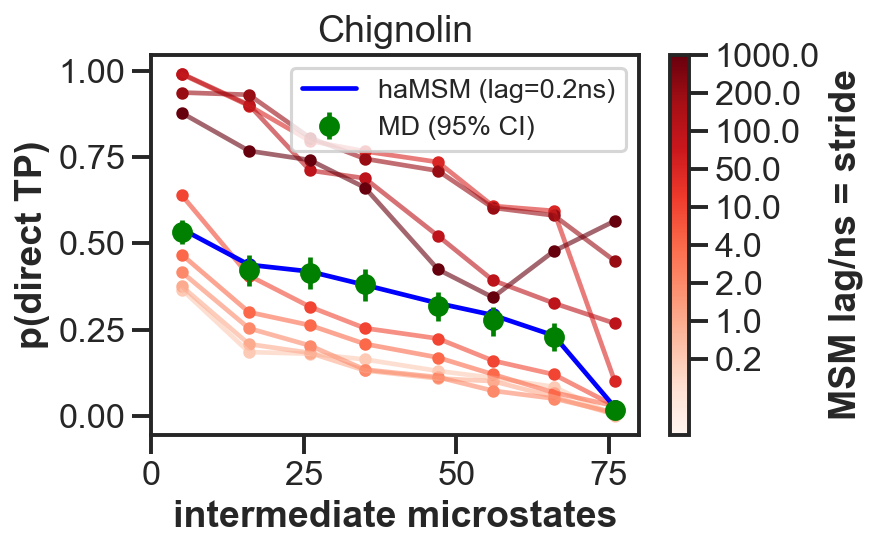

In [214]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = [i[msm_index] for i in pdirect_msms_cutoffs_strides]
    plt.scatter(intermediate_lens,y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens,y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')    

plt.errorbar(intermediate_lens, np.mean(pdirect_md_cutoffs, axis=1), yerr=[(np.mean(pdirect_md_cutoffs, axis=1)-np.percentile(pdirect_md_cutoffs, 2.5, axis=1)), (np.percentile(pdirect_md_cutoffs, 97.5, axis=1)-np.mean(pdirect_md_cutoffs, axis=1))], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, pdirect_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, pdirect_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('p(direct TP)', weight='bold')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pdirectTP_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: absolute error of p(x|TP) (indirect paths only)

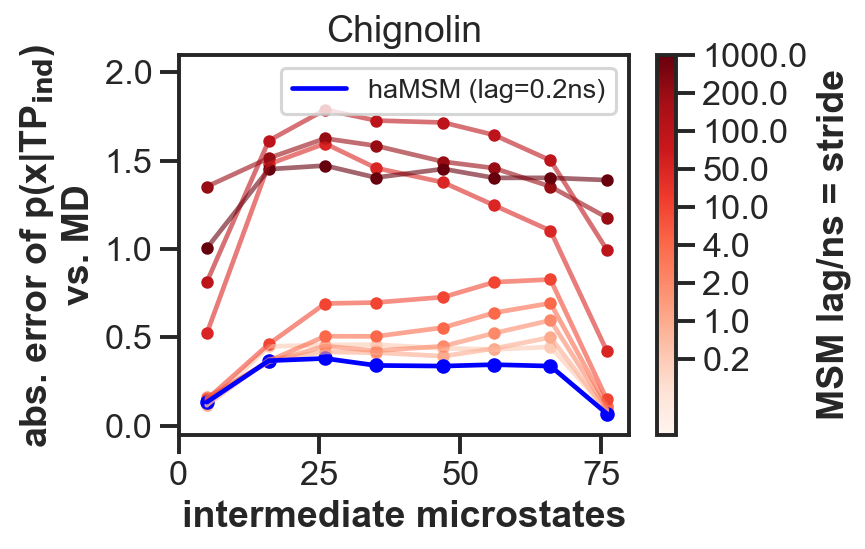

In [215]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_msms_cutoffs_strides[i][msm_index]) for i in range(len(counts_msms_cutoffs_strides))])
    plt.scatter(intermediate_lens, y, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y, color=cmap.to_rgba(msm_index), alpha=0.6)
    
cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold')  

plt.scatter(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), s=30, color='blue')
plt.plot(intermediate_lens, np.array([abs_error(np.mean(counts_md_cutoffs[i], axis=0), counts_hamsms_cutoffs[i]) for i in range(len(counts_hamsms_cutoffs))]), color='blue', label='haMSM (lag=0.2ns)')

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('abs. error of p(x|TP$_\mathbf{ind}$) \nvs. MD', weight='bold')
plt.xticks(range(0,100,25))
plt.ylim(-0.05,2.1)
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_pxTPAE_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()

## plot: mean TP length

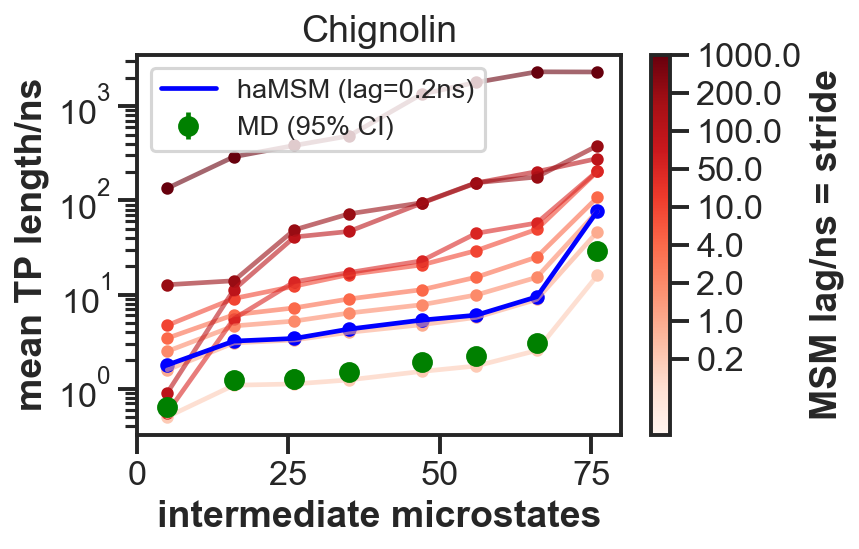

In [217]:
fig = plt.figure(dpi=150)
fig.patch.set_facecolor('white')

norm = matplotlib.colors.Normalize(vmin=-2, vmax=8)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Reds)
cmap.set_array([])

for msm_index in range(9):
    y = np.array([i[msm_index] for i in length_msms_cutoffs_strides])
    plt.scatter(intermediate_lens, y*0.2, s=20, color=cmap.to_rgba(msm_index))
    plt.plot(intermediate_lens, y*0.2, color=cmap.to_rgba(msm_index), alpha=0.6)

plt.errorbar(intermediate_lens, np.mean(length_md_cutoffs, axis=1)*0.2, yerr=[(np.mean(length_md_cutoffs, axis=1)-np.percentile(length_md_cutoffs, 2.5, axis=1))*0.2, (np.percentile(length_md_cutoffs, 97.5, axis=1)-np.mean(length_md_cutoffs, axis=1))*0.2], color='green', label='MD (95% CI)', fmt='o')

plt.scatter(intermediate_lens, length_hamsms_cutoffs, s=30, color='blue')
plt.plot(intermediate_lens, length_hamsms_cutoffs, color='blue', label='haMSM (lag=0.2ns)')

cbar = plt.colorbar(cmap)
cbar.set_ticks(range(9))
cbar.set_ticklabels(lags[:9]*0.2)
cbar.set_label('MSM lag/ns = stride', weight='bold') 

plt.xlabel('intermediate microstates', weight='bold')
plt.ylabel('mean TP length/ns', weight='bold')
plt.yscale('log')
plt.xticks(range(0,100,25))
plt.title('{}'.format(system_name))
plt.legend(fontsize=13)

plt.tight_layout()
plt.savefig('{}_TPlength_vsnomicrostates_strideeqlag.pdf'.format(system_name))

plt.show()